## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [48]:
# Your code here - remember to use markdown cells for comments as well!
# Predict housing prices to be used by PE shop looking for valuation help.

In [49]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
%matplotlib inline

In [50]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [51]:
# import the dataset
raw_data = pd.read_csv('kc_house_data.csv')

In [52]:
# examine the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [53]:
# drop the id column as that won't be relevant
clean_data = raw_data.drop('id', axis=1)

In [54]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [55]:
# Handle Missing Values
# waterfront, yr_renovated, view

# evaluate waterfront
clean_data['waterfront'].nunique()

2

In [56]:
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [57]:
# how many nans are there
clean_data['waterfront'].isna().sum()

2376

In [58]:
# given how many values this is, going to keep data in for now
# set all nans to 0 as houses missing waterfront info likely are not 
# waterfront
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [59]:
# Handle yr_renovated missing values
clean_data['yr_renovated'].nunique()

70

In [60]:
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [61]:
# how many are missing
clean_data['yr_renovated'].isna().sum()

3842

In [62]:
# similar to waterfront, assume missing data are 0's are non-renos
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [63]:
# Handle view missing values
clean_data['view'].isna().sum()

63

In [64]:
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [65]:
# view is the number of times a house has been viewed
# set missing values to 0 with the assumption that missing values have
# no views
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [66]:
# check for remaining missing values
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [67]:
# no more missing values
# check for duplicates
clean_data.duplicated().sum()

0

In [68]:
# There are no duplicates -- handle strings and convert all columns
# to appropriate d type for regression
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [69]:
# only string columns are the date and sqft_basement
# evaluate sqft_basement
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [70]:
# replace '?' with zero with assumption that these do not have basements
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace='?',
                                                                      value='0.0')

In [71]:
# convert to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [72]:
# handle date column - convert to a datetime type and then split year, month, day
clean_data['date'] = pd.to_datetime(clean_data['date'], infer_datetime_format=True)

In [73]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  float64       
 8   view           21597 non-null  float64       
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  float64       
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  float64       
 15  zipcode        2159

In [74]:
# create individual columns for year, month, and day
clean_data['year_sold'] = clean_data['date'].map(lambda x: x.year)
clean_data['month_sold'] = clean_data['date'].map(lambda x: x.month)
clean_data['day_sold'] = clean_data['date'].map(lambda x: x.day)

In [75]:
# drop date column
clean_data = clean_data.drop('date', axis=1)

In [76]:
# now we have handled missing values, duplicates, obvious weird values,
# and changed the types of columns appropriately
# check that columns are looking ok
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

In [77]:
# function to perform stepwsise selection
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [78]:
# test that feature selection is working properly
import statsmodels.api as sm

y = clean_data['price']
X = clean_data.drop('price', axis=1)
predictors = sm.add_constant(X)

In [79]:
# checking that stepwise selection is working
result = stepwise_selection(predictors, clean_data['price'], verbose=True)
print(result)

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  grade                          with p-value 0.0
Add  const                          with p-value 0.0
Add  view                           with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  lat                            with p-value 0.0
Add  waterfront                     with p-value 1.29672e-257
Add  bedrooms                       with p-value 8.75416e-67
Add  zipcode                        with p-value 1.06383e-41
Add  long                           with p-value 9.42956e-55
Add  year_sold                      with p-value 1.98049e-22
Add  condition                      with p-value 7.21359e-22
Add  sqft_above                     with p-value 4.79388e-22
Add  yr_renovated                   with p-value 3.12868e-09
Add  sqft_living15                  with p-value 3.91485e-09
Add  sqft_lot15                     with p-value 7.41754e-07
Add  sqft_basement

In [80]:
# stepwise feature selection seems to be working
# evaluate distributions / relationships, etc.
# separate continious and cat variables; remove cont variables that do not meet linearity req
# run a baseline model, evaluate residuals for assumption requirements
# cross fold validation

In [81]:
# Look at dependent variable: price

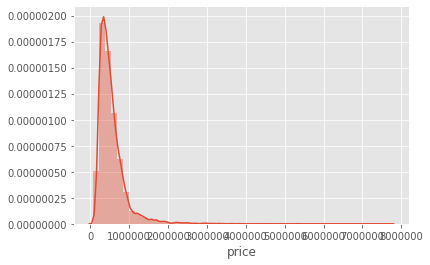

In [82]:
sns.distplot(clean_data['price'])

In [83]:
# distribution of price has significant right skew and positive outliers
# would likely benefit from log transformation -- will handle this after baseline model

In [84]:
"""
Function to plot y vs. a chosen set of x variables
"""

def plot_relationship(data, y_vars, x_vars, height=4.5):
    grid = sns.PairGrid(data=data, y_vars=y_vars, x_vars=x_vars, height=height)
    grid.map(sns.regplot)

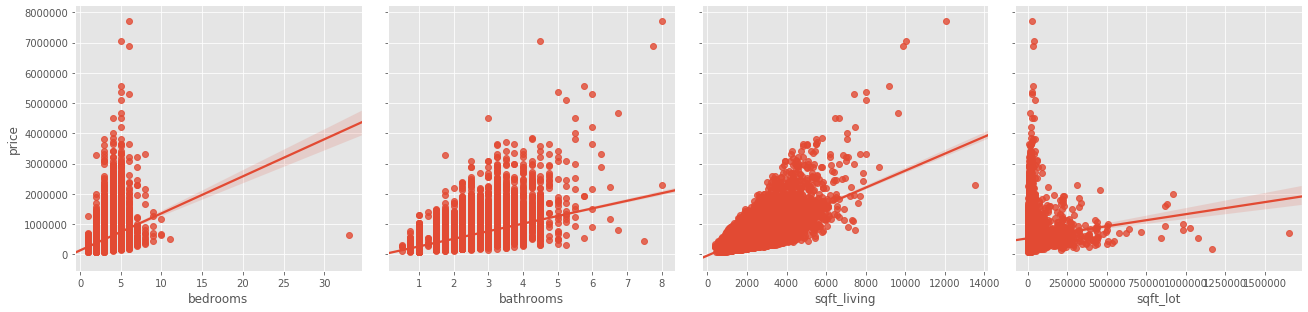

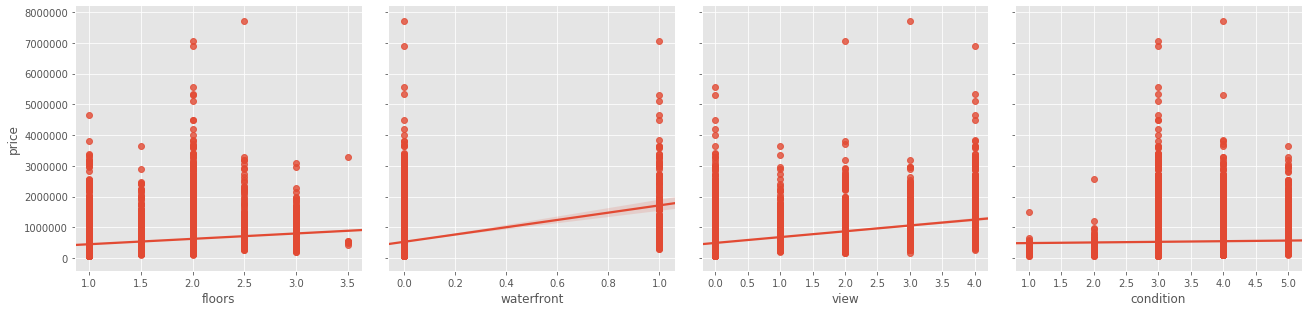

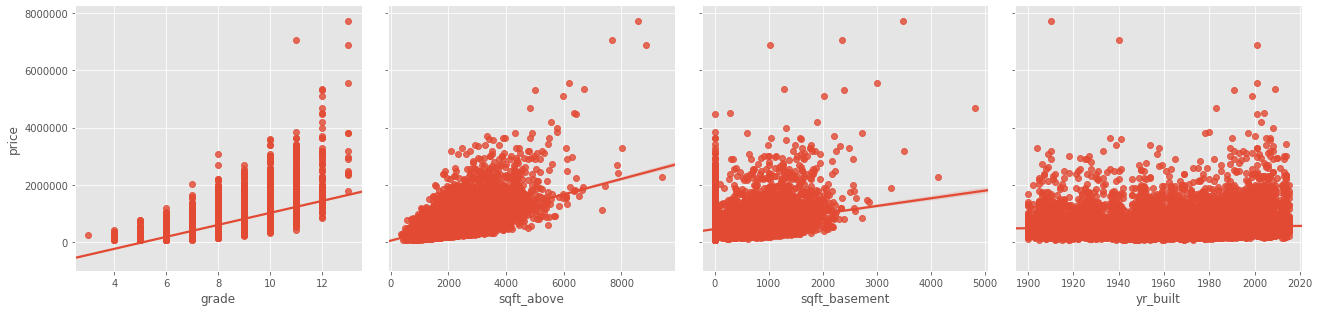

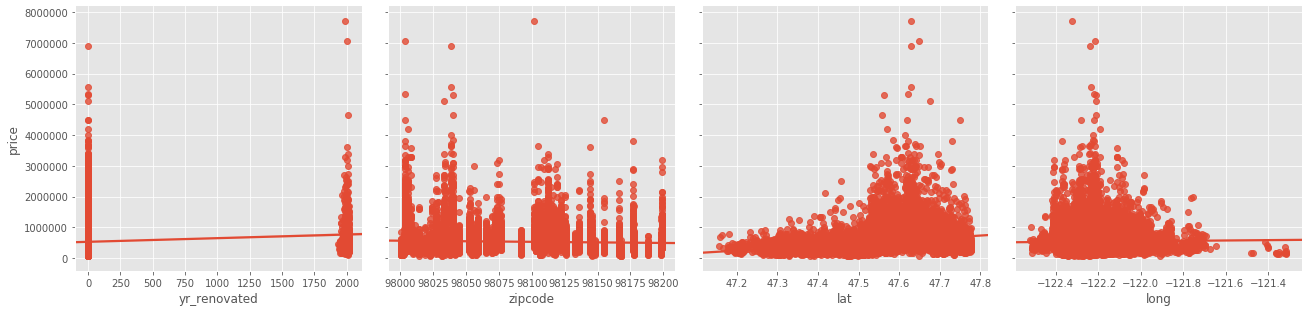

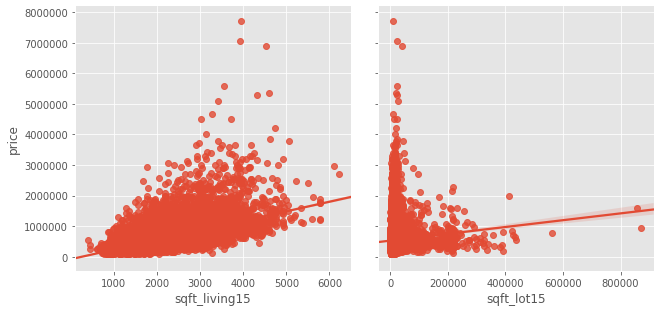

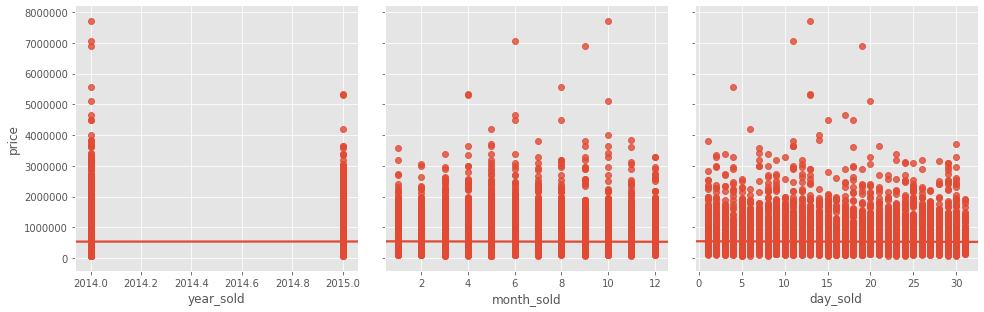

In [85]:
# plot all against price
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living15', 'sqft_lot15'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

In [86]:
# identify categorical and non-cat columns
cat_columns = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'year_sold', 
               'month_sold', 'day_sold']

In [87]:
cont_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15']

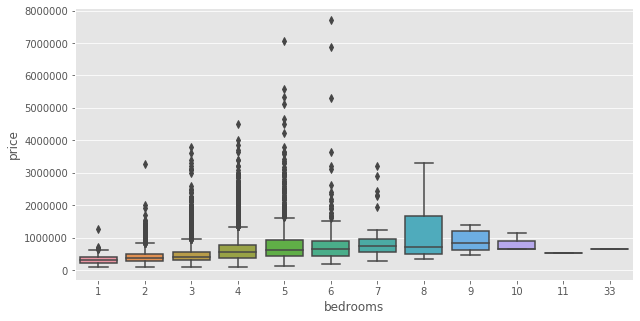

In [88]:
# handle categorical columns first
# first will need to identify which categorical columns have an ordinal relationship with price
# plot boxplots of each cat variable to see if it is ordinal or not

# Bedrooms
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='bedrooms', y='price', data=clean_data)
plt.show()

In [89]:
# there appears to be an ordinal relationship here, will leave as a single column for now

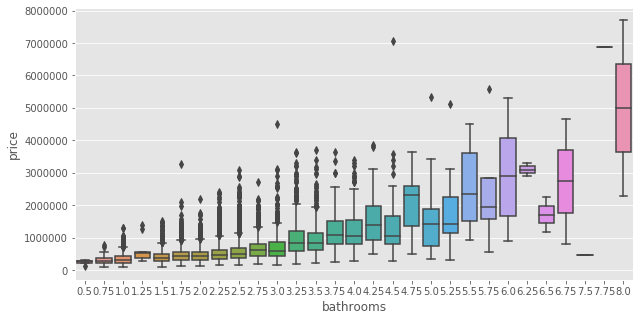

In [91]:
# Bathrooms
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='bathrooms', y='price', data=clean_data)
plt.show()

In [100]:
# ordinal relationship, leave as a single column

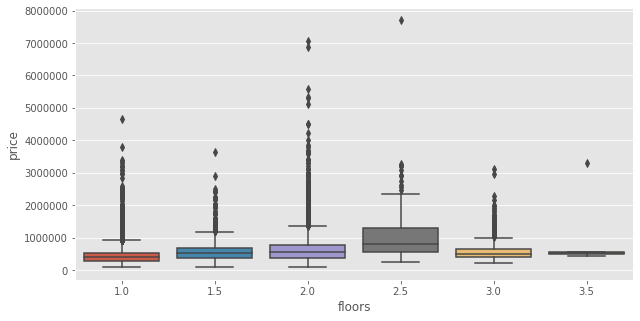

In [101]:
# floors
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='floors', y='price', data=clean_data)
plt.show()

In [102]:
# no clear ordinal relationship
# create DUMMY VARIABLE

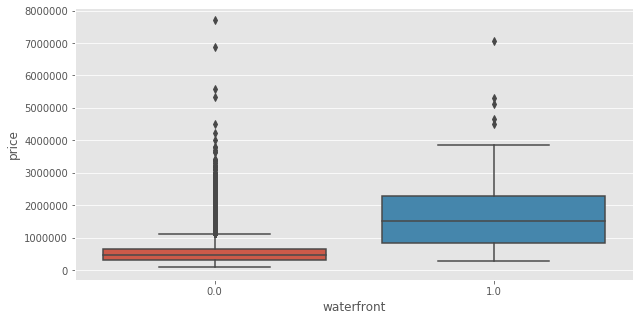

In [103]:
# waterfront
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='waterfront', y='price', data=clean_data)
plt.show()

In [104]:
# CREATE DUMMY

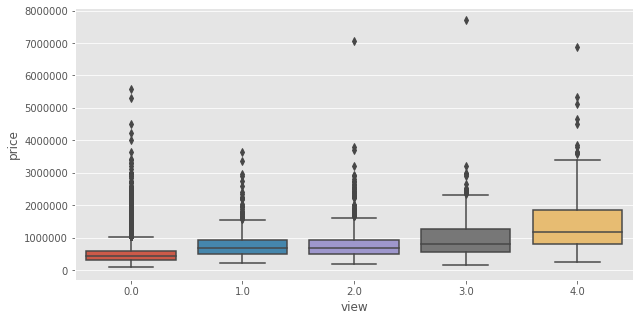

In [105]:
# view
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='view', y='price', data=clean_data)
plt.show()

In [106]:
# slight ordinal relationship, leave as a single column for now

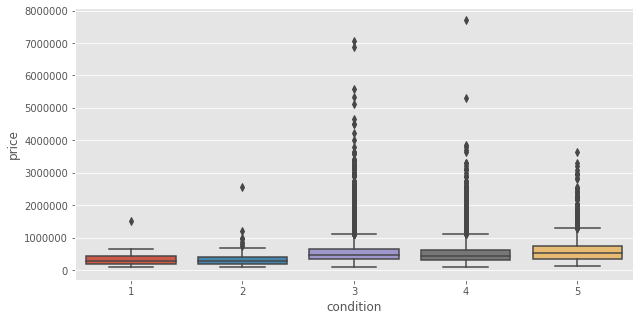

In [107]:
# condition
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='condition', y='price', data=clean_data)
plt.show()

In [108]:
# no clear ordinal relationship
# CREATE DUMMY

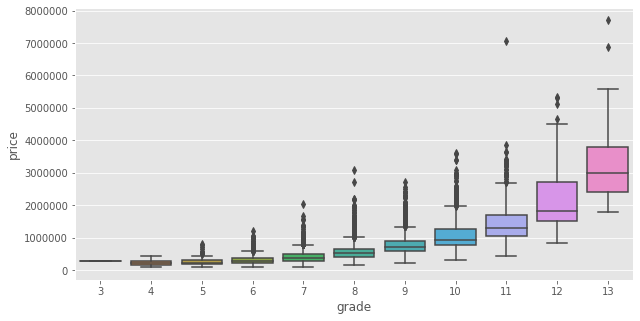

In [109]:
# grade
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='grade', y='price', data=clean_data)
plt.show()

In [110]:
# clear ordinal relationship
# potentially exponential?

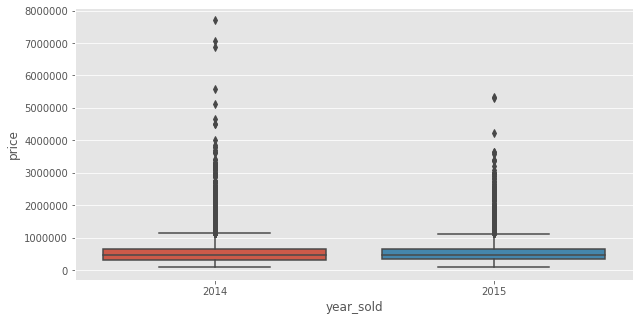

In [111]:
# year_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='year_sold', y='price', data=clean_data)
plt.show()

In [112]:
# OHE

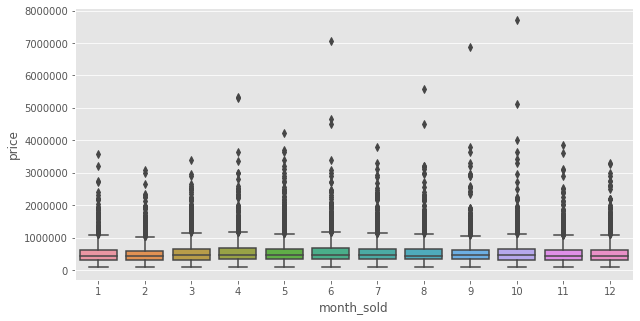

In [98]:
# month_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='month_sold', y='price', data=clean_data)
plt.show()

In [113]:
# OHE

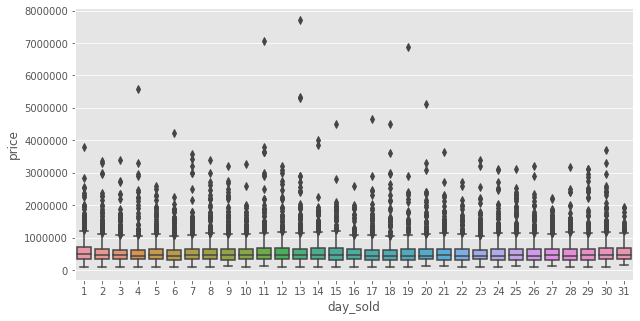

In [99]:
# day_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='day_sold', y='price', data=clean_data)
plt.show()

In [114]:
# OHE

In [115]:
# create dummy variables
floors_dummies = pd.get_dummies(clean_data['floors'], prefix='floors', drop_first=True)
waterfront = pd.get_dummies(clean_data['waterfront'], prefix='waterfront', drop_first=True)
condition = pd.get_dummies(clean_data['condition'], prefix = 'condition', drop_first=True)
year_sold = pd.get_dummies(clean_data['year_sold'], prefix='year_sold', drop_first=True)
month_sold = pd.get_dummies(clean_data['month_sold'], prefix='month_sold', drop_first=True)
day_sold = pd.get_dummies(clean_data['day_sold'], prefix='day_sold', drop_first=True)

In [116]:
cont_columns

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [ ]:
# evaluate cont variables for linearity assumptions
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])